# Big Data Management Project 1:
## Analyzing New York City Taxi Data

In [1]:
!pip install shapely

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, unix_timestamp, col, lag, avg, lead, count, sum as spark_sum
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType
from pyspark.sql.window import Window

import json
import time

from shapely.geometry import shape, Point

In [3]:
spark = (SparkSession.builder
                    .appName('BDM_Project1')
                    .enableHiveSupport()
                    .getOrCreate()
        )

### NYC Borough Data

In [4]:
with open('input/nyc-boroughs.geojson') as f:
    geo_data = json.load(f)

# Broadcasting data to workers
broadcast_geo_data = spark.sparkContext.broadcast(geo_data)

# Creating a dictionary of borough codes and polygons within the borough
polygons = {}
b_names = {} # borough names by code

for feature in broadcast_geo_data.value['features']:
    
    code = feature['properties']['boroughCode']
    name = feature['properties']['borough']

    if code not in polygons:
        polygons[code] = []
        b_names[code] = name
    
    polygons[code].append(shape(feature['geometry']))

# Sorting borough polygons by area
for code in polygons: 
    polygons[code] = sorted(
        polygons[code], key=lambda x: x.area, reverse=True
    )

In [5]:
# UDF: longitude, latitude -> borough
def get_borough(long, lat):
    point = Point(long, lat)
    
    for code, pols in polygons.items():
        for polygon in pols:
            if polygon.contains(point):
                return code
    
    return None

get_borough_udf = udf(get_borough, IntegerType())

### NYC Taxi Data

In [6]:
start_time = time.time() # To see the time it takes to execute data transformations

# Defining the schema for faster reading of data
schema = StructType([
    StructField("medallion", StringType(), True),
    StructField("hack_license", StringType(), True),
    StructField("vendor_id", StringType(), True),
    StructField("rate_code", StringType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("pickup_datetime", TimestampType(), True),
    StructField("dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", StringType(), True),
    StructField("trip_time_in_secs", StringType(), True),
    StructField("trip_distance", StringType(), True),
    StructField("pickup_longitude", DoubleType(), True),
    StructField("pickup_latitude", DoubleType(), True),
    StructField("dropoff_longitude", DoubleType(), True),
    StructField("dropoff_latitude", DoubleType(), True)
])

# Creating a single dataframe of all the trip_data files
taxi_df_og = (spark.read
             .option("sep", ",")
             .option("header", True)
             .schema(schema)
             .csv("input/trip_data/trip_data_*.csv")
             #.csv(["input/trip_data/trip_data_1.csv"])
          )

# Moving the trips with 0 passengers to a separate dataframe, these will be added to idle times?
zero_passenger_count = taxi_df_og.filter(taxi_df_og.passenger_count == "0")

# Transforming the data (further explained in the project report)
taxi_df = taxi_df_og.filter(
    (taxi_df_og.passenger_count != "0") &
    ~(
        (taxi_df_og.trip_distance == 0) & 
        (taxi_df_og.pickup_longitude == taxi_df_og.dropoff_longitude) &
        (taxi_df_og.pickup_latitude == taxi_df_og.dropoff_latitude)
    )
).withColumns({
    "pickup_ts": unix_timestamp("pickup_datetime", "dd-MM-yy HH:mm"),
    "dropoff_ts": unix_timestamp("dropoff_datetime", "dd-MM-yy HH:mm")
}).withColumn(
    "duration", (col("dropoff_ts") - col("pickup_ts")) * 1000 # convert to milliseconds
).filter(
    (col("duration") > 0) & (col("duration") <= 4 * 60 * 60 * 1000)
).select(
    "hack_license",
    "pickup_latitude",
    "pickup_longitude",
    "pickup_ts",
    "dropoff_latitude",
    "dropoff_longitude",
    "dropoff_ts",
    "duration"
).dropna()

# Adding pick up and drop off boroughs to taxi data
taxi_df = taxi_df.withColumn(
    "pickup_borough", get_borough_udf("pickup_longitude", "pickup_latitude")
).withColumn(
    "dropoff_borough", get_borough_udf("dropoff_longitude", "dropoff_latitude")
)
taxi_df.show(3, truncate=False)

print("Execution time", time.time() - start_time)

+--------------------------------+---------------+----------------+----------+----------------+-----------------+----------+--------+--------------+---------------+
|hack_license                    |pickup_latitude|pickup_longitude|pickup_ts |dropoff_latitude|dropoff_longitude|dropoff_ts|duration|pickup_borough|dropoff_borough|
+--------------------------------+---------------+----------------+----------+----------------+-----------------+----------+--------+--------------+---------------+
|BA96DE419E711691B9445D6A6307C170|40.757977      |-73.978165      |1357053108|40.751171       |-73.989838       |1357053490|382000  |1             |1              |
|9FD8F69F0804BDB5549F40E9DA1BE472|40.731781      |-74.006683      |1357431515|40.75066        |-73.994499       |1357431774|259000  |1             |1              |
|9FD8F69F0804BDB5549F40E9DA1BE472|40.73777       |-74.004707      |1357411781|40.726002       |-74.009834       |1357412063|282000  |1             |1              |
+---------

### Query 1
Utilization: idle time per taxi

In [10]:
# Copy taxi_df dataframe
taxi_sample = taxi_df.limit(20000)
taxi_copy = taxi_sample.select("*")

# Ensure all trips of the same driver are together
taxi_copy = taxi_copy.repartition("hack_license")

# Partition by driver and then order by pickup time with Window
window_sp = Window.partitionBy("hack_license").orderBy("pickup_ts")

# Compute previous dropoff time
taxi_copy = taxi_copy.withColumn("prev_dropoff_ts", lag("dropoff_ts").over(window_sp))

# Compute idle time
taxi_copy = taxi_copy.withColumn("idle_time", col("pickup_ts") - col("prev_dropoff_ts"))

taxi_copy.persist()

# Control that ride is not over 4h
taxi_copy = taxi_copy.filter((col("idle_time").isNotNull()) & (col("idle_time") <= 14400))

# Group by driver and sum idle time
result = taxi_copy.groupBy("hack_license").agg(spark_sum("idle_time").alias("total_idle_time"))

result.show()

taxi_copy.unpersist()

+--------------------+---------------+
|        hack_license|total_idle_time|
+--------------------+---------------+
|02856AFC22881ABCA...|           2640|
|03A2D28F831C5C3E5...|           6300|
|0FBF11956EE14B253...|            120|
|13CD9D132F9DFE9BD...|            300|
|31195E1D3AA1EC26D...|           2100|
|3183016714F5E253E...|           5640|
|428AE5AF18511D16B...|          12180|
|42D2B75CA34A867A4...|           8520|
|49EE1E8ECFA1C6D35...|           7260|
|4CEC9B9F46ABAB3AD...|           2640|
|669FA40A7222D4DC2...|          11640|
|69996930170E51265...|           4980|
|7DA853581E8C09723...|          11340|
|83279FE1F7D548407...|           6120|
|8821CA9250E34A869...|           2220|
|88B5A703C9407B0B3...|           6780|
|980A15AE7BF88E611...|          26700|
|A169B687A86BDE3FE...|           3540|
|A7C47E60941315A0E...|           6000|
|A7EE9AEDB7325F55F...|           3240|
+--------------------+---------------+
only showing top 20 rows



DataFrame[hack_license: string, pickup_latitude: double, pickup_longitude: double, pickup_ts: bigint, dropoff_latitude: double, dropoff_longitude: double, dropoff_ts: bigint, duration: bigint, pickup_borough: int, dropoff_borough: int, prev_dropoff_ts: bigint, idle_time: bigint]

### Query 2
The average time it takes for a taxi to find its next fare(trip) per destination borough

+-------------+------------------+
| borough_name|  avg_waiting_time|
+-------------+------------------+
|    Manhattan|2397.5843868229213|
|        Bronx| 3261.315789473684|
|     Brooklyn|3325.5047318611987|
|       Queens| 4060.951592356688|
|Staten Island|            9630.0|
+-------------+------------------+



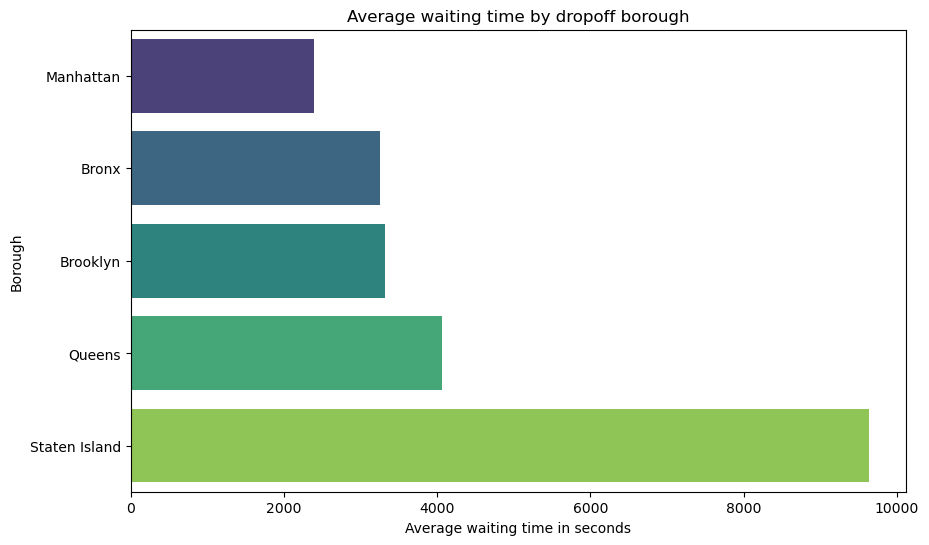

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
window_spec = Window.partitionBy("hack_license").orderBy("pickup_ts")

# Get the next pickup time
taxi_sample = taxi_df.limit(20000)
next_pick_up = taxi_sample.withColumn("next_pickup_ts", lead("pickup_ts").over(window_spec))

# Calculate waiting time
wait_time = next_pick_up.withColumn("waiting_time", (next_pick_up["next_pickup_ts"] - next_pick_up["dropoff_ts"]))

# Filter out null values, null boroughs, and waiting times > 4 hours
wait_time = wait_time.na.drop(subset=["next_pickup_ts"])
wait_time = wait_time.filter(wait_time["dropoff_borough"].isNotNull())
wait_time = wait_time.filter(col("waiting_time") <= 14400)

# Calculate average waiting time by dropoff borough
result = wait_time.groupBy("dropoff_borough").agg(avg("waiting_time").alias("avg_waiting_time"))

# Create df from borough names
borough_names_df = spark.createDataFrame([(code, name) for code, name in b_names.items()],
                                         ["dropoff_borough", "borough_name"])
query2_result = result.join(borough_names_df, on="dropoff_borough", how="left")
query2_result = query2_result.select("borough_name", "avg_waiting_time").orderBy("avg_waiting_time")

query2_result.show()

#vizualise
query2_pandas = query2_result.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=query2_pandas, x="avg_waiting_time", y="borough_name", hue="borough_name", palette="viridis", legend=False)
plt.xlabel("Average waiting time in seconds")
plt.ylabel("Borough")
plt.title("Average waiting time by dropoff borough")
plt.show()

### Query 3
The number of trips that started and ended within the same borough

In [11]:
taxi_sample = taxi_df.limit(20000)
sumOfTripsBoroughSame = taxi_sample.filter(col("pickup_borough") == col("dropoff_borough")).count()
print(sumOfTripsBoroughSame)

16497


### Query 4
The number of trips that started in one borough and ended in another one

In [12]:
taxi_sample = taxi_df.limit(20000)
sumOfTripsBoroughDifferent = taxi_sample.filter(col("pickup_borough") != col("dropoff_borough")).count()
print(sumOfTripsBoroughDifferent)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 